<a href="https://colab.research.google.com/github/dmamur/struct2prop/blob/main/add/embed_sto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ase
import pickle,re, glob,os,random,json
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Embedding,Dense,Dropout,Input,Concatenate,Flatten,Bidirectional,LSTM,Reshape
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
import keras.backend as K
from collections import defaultdict
from scipy.spatial.distance import cdist
from ase.io import read
from ase import Atoms
from scipy.ndimage import gaussian_filter1d
from ase.neighborlist import neighbor_list
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

def getpdf(atoms):
    r = np.arange(0,10,0.1)
    v = np.concatenate([[1],4*np.pi/3*(r[1:]**3 - r[:-1]**3)])
    i, d = neighbor_list('id', atoms, 10.0, self_interaction=False)
    pdfatoms=[]
    for k,l in enumerate(atoms):
        y = np.zeros(100)
        dist = np.round(d[i==k]*10)
        a,b=np.unique(dist, return_counts=True)
        np.put(y,a.astype(int)-1,b)
        pdfatoms.append(gaussian_filter1d(y/v,1))
    return np.asarray(pdfatoms)

def getTypesXYZ(file):
    xyz=[]
    types=[]
    lattice=file['structure']['lattice']['matrix']
    for n in file['structure']['sites']:
        types.append(n['label'])
        xyz.append(n['xyz'])
        #print(n['label'],n['xyz'])
    return types,lattice,np.asarray(xyz)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 7.6 MB/s eta 0:00:00


In [2]:
!git clone https://github.com/dmamur/struct2prop.git

Cloning into 'struct2prop'...
remote: Enumerating objects: 208, done.
remote: Counting objects: 100% (134/134), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 208 (delta 63), reused 125 (delta 59), pack-reused 74
Receiving objects: 100% (208/208), 32.43 MiB | 17.95 MiB/s, done.
Resolving deltas: 100% (85/85), done.


In [3]:
class Config:
    MAX_LEN = 8
    BATCH_SIZE = 16
    LR = 0.001
    VOCAB_SIZE = 128
    EMBED_DIM = 128
    MNAME = 'embed_sto_'
config = Config()
path="/content/struct2prop/models"
mname=path+config.MNAME+'E_'+str(config.EMBED_DIM)
tf.random.set_seed(42)
pickle_file_path = "/content/trainData_sto.pkl"

# Load data from zip

In [4]:
%%time
# Check if the pickle file already existscx v
if not os.path.isfile(pickle_file_path):
    if not os.path.isfile('/content/sto_dos.tar.gz'):
    # Download and extract data
      !wget https://figshare.com/ndownloader/files/34517867 -O sto_dos.tar.gz
      !cp /content/34517867 /content/sto_dos.tar.gz
      !tar xvf sto_dos.tar.gz

    Cell, Types, Xyz, Label, rdfs, dosV, ids, formula = [], [], [], [], [], [], [], []
    # Process each file
    for n1 in range(0,4986):
        n = f'/content/data/{n1}.npy'
        atoms=read(f'/content/data/{n1}.vasp',format='vasp')
        formula.append(atoms.get_chemical_formula())
        Types.append(atoms.get_chemical_symbols())
        ids.append(str(n1))
        Xyz.append(atoms.positions)
        Cell.append(atoms.cell)
        rdfs.append(getpdf(atoms))
        dosV.append(np.load(f'/content/data/{n1}.npy'))

    # Create a dictionary to store the data
    db = {
        'types': Types,
        'formula': formula,
        'pdf': rdfs,
        'Cell': Cell,
        'xyz': Xyz,
        'dosV': dosV,
        'ids': ids
    }

    # Save the dictionary as a pickle file
    with open(pickle_file_path, "wb") as f:
        pickle.dump(db, f)

Streaming output truncated to the last 5000 lines.
data/3890.vasp
data/927.npy
data/2138.npy
data/4587.vasp
data/4233.npy
data/1429.npy
data/3900.vasp
data/1175.npy
data/3524.npy
data/3448.vasp
data/3270.npy
data/3341.vasp
data/2815.npy
data/4910.npy
data/501.npy
data/2171.vasp
data/2263.npy
data/520.vasp
data/1808.npy
data/4655.vasp
data/1315.vasp
data/2318.vasp
data/1554.npy
data/3251.vasp
data/616.vasp
data/765.npy
data/126.vasp
data/3586.vasp
data/2734.vasp
data/4470.vasp
data/4619.npy
data/4012.vasp
data/2940.npy
data/2000.npy
data/326.npy
data/4067.npy
data/1933.npy
data/3358.npy
data/488.vasp
data/4380.vasp
data/2649.npy
data/4744.npy
data/602.vasp
data/2456.vasp
data/112.vasp
data/4490.npy
data/3307.vasp
data/3329.vasp
data/208.vasp
data/1211.vasp
data/2097.npy
data/4335.vasp
data/4192.npy
data/1388.npy
data/3737.npy
data/41.npy
data/3483.npy
data/164.npy
data/2774.npy
data/474.vasp
data/1125.npy
data/1120.vasp
data/3220.npy
data/4076.vasp
data/4733.vasp
data/2511.npy
data/1767

In [5]:
with open(pickle_file_path, "rb") as f:
    db = pickle.load(f)

types = db['types']
pdf = db['pdf']
ids = db['ids']

In [6]:
# Load dictionary
with open('/content/struct2prop/data/el2id.pkl', 'rb') as f:
    el2id = pickle.load(f)
element2id = el2id['el2id']
config.VOCAB_SIZE = len(element2id)
print(config.VOCAB_SIZE)

94


In [7]:
lens = [len(i) for i in types]
print(max(lens))
types[0]

['Sr', 'O', 'O', 'O', 'Ti']

In [8]:
# Convert element labels to numerical IDs
typesNumerical = [[element2id[element] for element in row] for row in types]

# Pad sequences for pdf (assuming pdf is a list of arrays)
x1 = tf.keras.preprocessing.sequence.pad_sequences(pdf, dtype='float32', padding='post', truncating='post', maxlen=config.MAX_LEN)

# Pad sequences for typesNumerical
x3 = tf.keras.preprocessing.sequence.pad_sequences(typesNumerical, dtype='int32', padding='post', truncating='post', maxlen=config.MAX_LEN)


In [9]:
x4 = [np.asarray(i[2,0,::4]) for i in db['dosV']]
y  = scaler.fit_transform(np.asarray([np.asarray(i[2,2,::4]) for i in db['dosV']]))

In [10]:
x4 = tf.keras.preprocessing.sequence.pad_sequences(x4,dtype='float32',padding= 'post')
y  = tf.keras.preprocessing.sequence.pad_sequences(y,dtype='float32',padding= 'post')
p = np.random.RandomState(seed=73).permutation(y.shape[0])
n = len(p)
trainidx = p[:int(n*0.8)]
validx = p[int(n*0.8):int(n*0.9)]
testidx = p[int(n*0.9):]

# Predict eDOS

In [11]:
# Input layer for x1
inputA = Input(shape=x1.shape[1:], name='x1')

# Input layer for types (assuming types have integer values)
inputC = Input((config.MAX_LEN,), dtype=tf.int32, name='types')

# Input layer for eDOS energies
inputD = Input(shape=x4.shape[1:],)

# Output layer neuron count
outNeuronNum = y.shape[1]

# Input layer for outNeuronNum
inputD = Input(shape=outNeuronNum)

# LSTM layer for x1
x = Bidirectional(LSTM(8, name='x1_lstm', return_sequences=True), name='x1_blstm')(inputA)
x = Model(inputs=inputA, outputs=x)

# Embedding layer for types
z = Embedding(config.VOCAB_SIZE, config.EMBED_DIM, mask_zero=True, name="element_embdgs")(inputC)
z = Model(inputs=inputC, outputs=z)

# EDOS energy values as an input
d = Dense(config.MAX_LEN, activation="linear",use_bias=True)(inputD)
d = Reshape((config.MAX_LEN,1))(d)
d = Dropout(0.1)(d)
d = Model(inputs=inputD, outputs=d)

# Concatenate the output of x and z
combined = Concatenate()([x.output,z.output,d.output])

# LSTM layer on the concatenated output
l = LSTM(128)(combined)

# Dense layer for the final output
e = Dense(outNeuronNum, activation="relu", use_bias=True, name='out_edos')(l)

# Create the final model
model = Model(inputs=[x.input, z.input, d.input], outputs=[e])


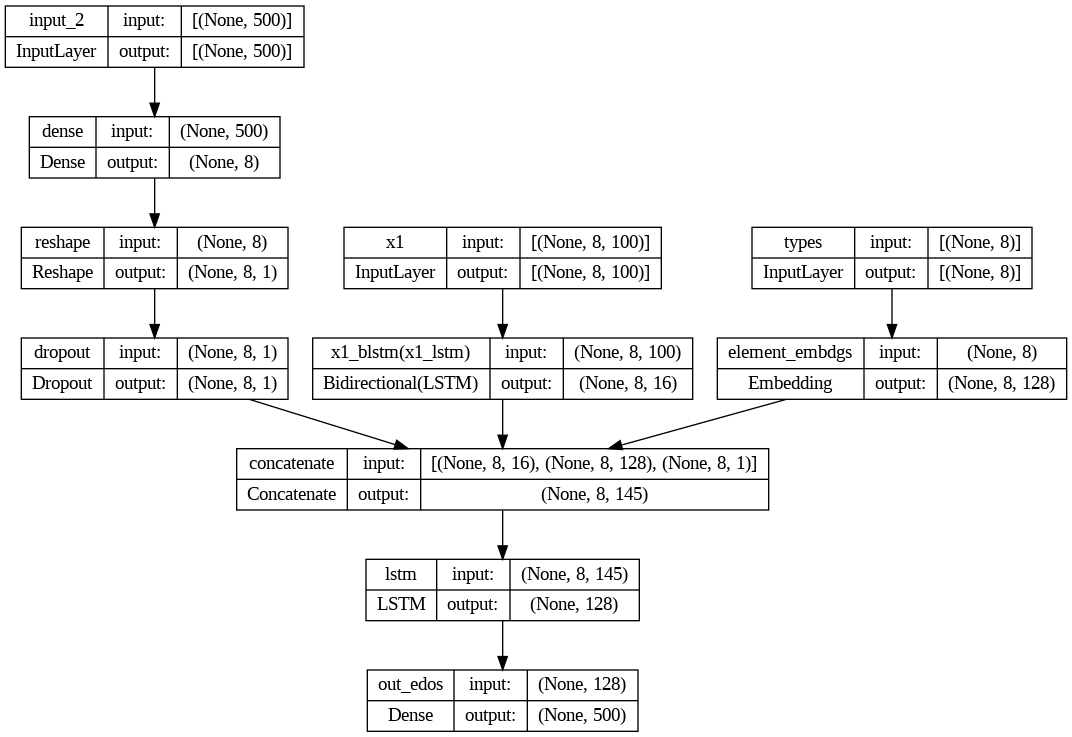

In [12]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [13]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 500)]                0         []                            
                                                                                                  
 dense (Dense)               (None, 8)                    4008      ['input_2[0][0]']             
                                                                                                  
 x1 (InputLayer)             [(None, 8, 100)]             0         []                            
                                                                                                  
 types (InputLayer)          [(None, 8)]                  0         []                            
                                                                                            

In [14]:
model.compile(loss ='mae',
              optimizer= keras.optimizers.Adam(learning_rate=config.LR),
              metrics='mse', run_eagerly=True)

In [15]:
def scheduler(epoch):
    initial_lrate = config.LR
    drop = 0.92
    epochs_drop = 8
    lr = initial_lrate * np.power(drop, np.floor((1+epoch)/epochs_drop))

    return max(lr, 0.0001)

if os.path.isfile(mname+"_log.csv"):
    df = pd.read_csv(mname+"_log.csv")
    initEp = df['epoch'].to_numpy()[-1]+1
    model.load_weights(mname+".h5")
else:
    initEp = 0


# Define callback functions
csv_logger = tf.keras.callbacks.CSVLogger(mname + "_log.csv", append=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=50, min_delta=0.01)
checkpoint = tf.keras.callbacks.ModelCheckpoint(mname + ".h5", verbose=2, monitor='val_loss', mode='min', save_freq=5000)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Combine all callbacks into a list
callbacks_list = [checkpoint, csv_logger, early_stopping, lr_scheduler]

# Training configuration
epochs = 4 * config.BATCH_SIZE

# Train the model
hist = model.fit(x=[x1[trainidx], x3[trainidx], x4[trainidx]], y=[y[trainidx]],
                 validation_data=([x1[validx], x3[validx], x4[validx]], [y[validx]]),
                 initial_epoch=initEp, epochs=epochs, batch_size=config.BATCH_SIZE, callbacks=callbacks_list, verbose=1)


Epoch 1/64


250/250 [==============================] - 27s 86ms/step - loss: 0.0531 - mse: 0.0110 - val_loss: 0.0484 - val_mse: 0.0097 - lr: 0.0010
Epoch 2/64
250/250 [==============================] - 23s 92ms/step - loss: 0.0468 - mse: 0.0090 - val_loss: 0.0459 - val_mse: 0.0086 - lr: 0.0010
Epoch 3/64
250/250 [==============================] - 32s 130ms/step - loss: 0.0448 - mse: 0.0083 - val_loss: 0.0439 - val_mse: 0.0079 - lr: 0.0010
Epoch 4/64
250/250 [==============================] - 23s 93ms/step - loss: 0.0437 - mse: 0.0079 - val_loss: 0.0429 - val_mse: 0.0077 - lr: 0.0010
Epoch 5/64
250/250 [==============================] - 21s 86ms/step - loss: 0.0428 - mse: 0.0076 - val_loss: 0.0424 - val_mse: 0.0077 - lr: 0.0010
Epoch 6/64
250/250 [==============================] - 23s 94ms/step - loss: 0.0417 - mse: 0.0073 - val_loss: 0.0415 - val_mse: 0.0073 - lr: 0.0010
Epoch 7/64
250/250 [==============================] - 25s 98ms/step - loss: 0.0410 - mse: 0.0071 - val_loss: 0.0406 - val_mse: 0

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


250/250 [==============================] - 21s 85ms/step - loss: 0.0330 - mse: 0.0049 - val_loss: 0.0334 - val_mse: 0.0049 - lr: 8.4640e-04
Epoch 21/64
250/250 [==============================] - 23s 91ms/step - loss: 0.0329 - mse: 0.0048 - val_loss: 0.0331 - val_mse: 0.0049 - lr: 8.4640e-04
Epoch 22/64
250/250 [==============================] - 21s 83ms/step - loss: 0.0327 - mse: 0.0048 - val_loss: 0.0331 - val_mse: 0.0049 - lr: 8.4640e-04
Epoch 23/64
250/250 [==============================] - 23s 92ms/step - loss: 0.0326 - mse: 0.0048 - val_loss: 0.0330 - val_mse: 0.0049 - lr: 8.4640e-04
Epoch 24/64
250/250 [==============================] - 21s 86ms/step - loss: 0.0324 - mse: 0.0047 - val_loss: 0.0326 - val_mse: 0.0048 - lr: 7.7869e-04
Epoch 25/64
250/250 [==============================] - 23s 93ms/step - loss: 0.0323 - mse: 0.0047 - val_loss: 0.0327 - val_mse: 0.0048 - lr: 7.7869e-04
Epoch 26/64
250/250 [==============================] - 21s 86ms/step - loss: 0.0322 - mse: 0.0047 - 

In [16]:
# Make predictions
preds = model.predict([x1, x3, x4], batch_size=16)

# Create results dictionary
dbresults = {
    'x4':  x4,
    'y':  scaler.inverse_transform(y),
    'preds': scaler.inverse_transform(preds),
    'train_idx': trainidx,
    'validate_idx': validx,
    'test_idx': testidx,
    'ids': ids
}

# Save results to a pickle file
with open(f'{mname}_results.pkl', 'wb') as f:
    pickle.dump(dbresults, f)


312/312 [==============================] - 9s 28ms/step


MSE_test:  0.033562962 MAE_test:  0.06956716
mean_squared_error:  0.12387038
mean_absolute_error:  0.08761246


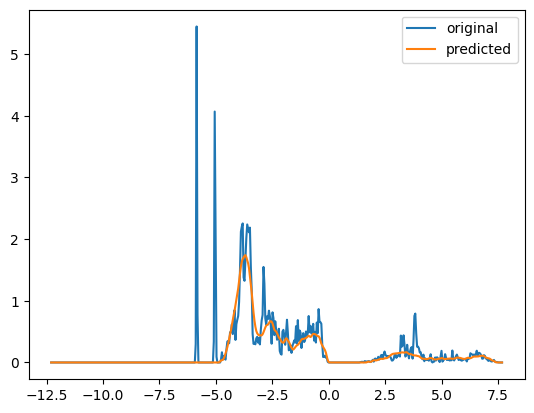

In [17]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,median_absolute_error
ytest    = dbresults['y'][testidx]
x4t      = dbresults['x4'][testidx]
predtest = dbresults['preds'][testidx]
mset = np.asarray([mean_squared_error(i,j) for i,j in zip(ytest,predtest)])
maet = np.asarray([mean_absolute_error(i,j) for i,j in zip(ytest,predtest)])
mseTt=np.mean(mset)
maeTt=np.mean(maet)
print('MSE_test: ',mseTt,'MAE_test: ',maeTt)
#formula = [dbresults['formula'][i] for i in testidx]
#ids = [dbresults['ids'][i] for i in testidx]
ind=np.random.randint(len(ytest))
p = np.random.permutation(np.where(mset>0.)[0])
ind=p[0]#np.random.randint(len(ytrain))
y_true = ytest[ind]
y_pred = predtest[ind]
plt.plot(x4t[ind],y_true,label='original')
plt.plot(x4t[ind],gaussian_filter1d(y_pred,1),label='predicted')
#plt.plot(x4t[ind],gaussian_filter1d(y_true,1))
print('mean_squared_error: ',mean_squared_error(y_true,y_pred))
print('mean_absolute_error: ',mean_absolute_error(y_true,y_pred))
#plt.title(formula[ind].translate(sub), fontsize=16)
plt.legend();